<a href="https://colab.research.google.com/github/atran13/MSc-Thesis-Signs-of-Gentrification/blob/main/Code/model__iter3_1_lr%3D0_01_bs%3D64_ep%3D60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

from __future__ import print_function, division

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler
from torchmetrics import ClasswiseWrapper, MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, glob, copy, random
from PIL import Image
from pandas.core.common import flatten

cudnn.benchmark = True
# plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.7 MB/s eta 0:00:00


## Load Data

### Create train-val-test split in data paths

In [ ]:
root_dir = '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS'

In [ ]:
all_image_paths = []
classes = []

for data_path in glob.glob(root_dir + '/*'):
    classes.append(data_path.split('/')[-1])
    all_image_paths.append(glob.glob(data_path + '/*'))

all_image_paths = list(flatten(all_image_paths))
data_size = len(all_image_paths)
random.seed(25)
random.shuffle(all_image_paths)

gen_count = 0
non_count = 0
for path in all_image_paths:
  label = path.split('/')[-2]
  if label == 'gentrified':
    gen_count +=1
  else:
    non_count +=1

print('Image path example: ', all_image_paths[0:3])
print('Classes: ', classes)
print('Dataset size (all):', data_size)
print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/data_size):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/data_size):.2f}%)')
print('------')

# split train val test from all paths (80,10,10)
train_image_paths, test_image_paths = all_image_paths[:int(0.8*len(all_image_paths))], all_image_paths[int(0.8*len(all_image_paths)):]
val_image_paths, test_image_paths = test_image_paths[:int(0.5*len(test_image_paths))], test_image_paths[int(0.5*len(test_image_paths)):]

for subset in (train_image_paths, val_image_paths, test_image_paths):
  subset_size = len(subset)
  gen_count = 0
  non_count = 0
  for path in subset:
    label = path.split('/')[-2]
    if label == 'gentrified':
      gen_count +=1
    else:
      non_count +=1
  print(f"Subset size: {subset_size}")
  print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/subset_size):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/subset_size):.2f}%)')
  print('---')

Image path example:  ['/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/osm-node-2721945914_poly-4.jpg', '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/733_rec-8.jpg', '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/243_rec-1.jpg']
Classes:  ['gentrified', 'non-gentrified']
Dataset size (all): 10079
Class ratio: gentrified - 2610 (25.90%) | non-gentrified - 7469 (74.10%)
------
Subset size: 8063
Class ratio: gentrified - 2092 (25.95%) | non-gentrified - 5971 (74.05%)
---
Subset size: 1008
Class ratio: gentrified - 238 (23.61%) | non-gentrified - 770 (76.39%)
---
Subset size: 1008
Class ratio: gentrified - 280 (27.78%) | non-gentrified - 728 (72.22%)
---


In [ ]:
df = pd.DataFrame(columns=['img','label'])

for path in train_image_paths:
    img = path.split('/')[-1]
    label = path.split('/')[-2]
    dic = {'img':[img], 'label':[label]}
    entry = pd.DataFrame.from_dict(dic)
    df = pd.concat([df, entry], ignore_index=True)

class_counts = df.label.value_counts()
class_weights = 1./class_counts; print(class_weights)
sample_weights = [1./class_counts[i] for i in df.label.values]

In [ ]:
# num_all = len(data_train)
# indices = list(range(num_all))

# train_indices, test_indices = train_test_split(indices, test_size=.09, random_state=25,
#                                                stratify=data_train.targets)
# data_train = torch.utils.data.Subset(data_train, train_indices)
# data_test = torch.utils.data.Subset(data_test, test_indices)

# train_indices1, val_indices = train_test_split(train_indices, test_size=.1, random_state=25,
#                                               stratify=[data_train.dataset.targets[i] for i in train_indices])
# data_train = torch.utils.data.Subset(data_train, train_indices1)
# data_val = torch.utils.data.Subset(data_val, val_indices)

### Define custom dataset and transformations

In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
# print(idx_to_class)
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(class_to_idx)

{'gentrified': 0, 'non-gentrified': 1}


In [ ]:
class Gentrification(ImageFolder):
  def __init__(self, paths, train=False):
    self.paths = paths
    self.transform = train
    self.data =[]
    for path in paths:
      class_name = path.split('/')[-2]
      self.data.append([path, class_name])

  def __len__(self) :
    return len(self.data)

  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    img = Image.open(img_path)
    label = class_to_idx[label]

    if self.transform:
      return transform_train(img), label
    else:
      return transform_val_test(img), label

In [ ]:
def transform_train(i):
  transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  t = transform(i)
  return t

def transform_val_test(i):
  transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  t = transform(i)
  return t

### Load data with random sampler

In [ ]:
data_train = Gentrification(train_image_paths, train=True)
data_val = Gentrification(val_image_paths, train=False)
data_test = Gentrification(test_image_paths, train=False)

In [ ]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(data_train), replacement=True)

In [ ]:
batch_size = 64
dataloaders = {
    'train': torch.utils.data.DataLoader(data_train, sampler=sampler, batch_size=batch_size, num_workers=2),
    'val': torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=2),
    'test': torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
for i, (data, target) in enumerate(dataloaders['train']):
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))
# {'gentrified': 0, 'non-gentrified': 1}

batch index 0, 0/1: 33/31
batch index 1, 0/1: 23/41
batch index 2, 0/1: 41/23
batch index 3, 0/1: 34/30


KeyboardInterrupt: ignored

In [ ]:
# print(next(iter(dataloaders['train'])))

In [ ]:
dataset_sizes = {
    'train' : len(data_train),
    'val' : len(data_val),
    'test' : len(data_test)
}
print(dataset_sizes)

{'train': 8063, 'val': 1008, 'test': 1008}


### Visualize images



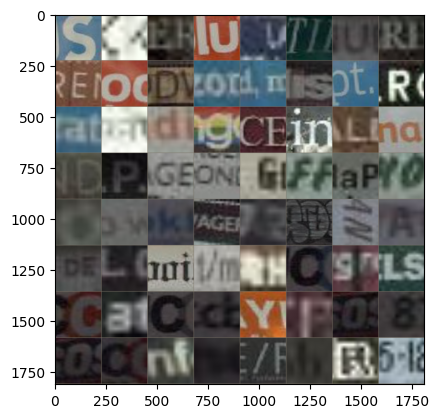

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(pano_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Train & test functions



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50): # add loader
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_F1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Metrics
            running_loss = 0.0
            metrics = MetricCollection({
                'Acc' : MulticlassAccuracy(num_classes=2, average='macro'),
                'P' : MulticlassPrecision(num_classes=2, average='macro'),
                'R' : MulticlassRecall(num_classes=2, average='macro'),
                'F1' : MulticlassF1Score(num_classes=2, average='macro'),
                })
            metrics = metrics.to(device)
            cls_metrics = MetricCollection({
                'cls_Acc' : ClasswiseWrapper(MulticlassAccuracy(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
                'cls_P' : ClasswiseWrapper(MulticlassPrecision(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
                'cls_R' : ClasswiseWrapper(MulticlassRecall(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
                'cls_F1' : ClasswiseWrapper(MulticlassF1Score(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified'])
                })
            cls_metrics = cls_metrics.to(device)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                metrics.update(preds, labels.data)
                cls_metrics.update(preds, labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_metrics = metrics.compute()
            epoch_cls_metrics = cls_metrics.compute()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_metrics["Acc"].item():.4f} P: {epoch_metrics["P"].item():.4f} R: {epoch_metrics["R"].item():.4f} F1: {epoch_metrics["F1"].item():.4f}')

            # deep copy the model
            if phase == 'val' and epoch_metrics['F1'] > best_F1:
                best_metrics = epoch_metrics
                best_cls_metrics = epoch_cls_metrics
                best_model_wts = copy.deepcopy(model.state_dict())

            metrics.reset()
            cls_metrics.reset()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Metrics of best model: Acc: {best_metrics["Acc"].item():.4f} P: {best_metrics["P"].item():.4f} R: {best_metrics["R"].item():.4f} F1: {best_metrics["F1"].item():.4f}')
    print('Classwise metrics of best model:')
    for k,v in best_cls_metrics.items():
        print(f'{k}: {v.item():.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test_model(model):
    running_loss = 0.0
    metrics = MetricCollection({
        'Acc' : MulticlassAccuracy(num_classes=2, average='macro'),
        'P' : MulticlassPrecision(num_classes=2, average='macro'),
        'R' : MulticlassRecall(num_classes=2, average='macro'),
        'F1' : MulticlassF1Score(num_classes=2, average='macro'),
        })
    metrics = metrics.to(device)
    cls_metrics = MetricCollection({
        'cls_Acc' : ClasswiseWrapper(MulticlassAccuracy(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_P' : ClasswiseWrapper(MulticlassPrecision(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_R' : ClasswiseWrapper(MulticlassRecall(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_F1' : ClasswiseWrapper(MulticlassF1Score(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified'])
        })
    cls_metrics = cls_metrics.to(device)

    with torch.no_grad():
        model.eval()
        for inputs,labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            metrics.update(preds, labels.data)
            cls_metrics.update(preds, labels.data)

        test_loss = running_loss / dataset_sizes['test']
        test_metrics = metrics.compute()
        test_cls_metrics = cls_metrics.compute()

        print(f'Test Loss: {test_loss:.4f} Acc: {test_metrics["Acc"].item():.4f} P: {test_metrics["P"].item():.4f} R: {test_metrics["R"].item():.4f} F1: {test_metrics["F1"].item():.4f}')
        print('Test classwise metrics:')
        for k,v in test_cls_metrics.items():
            print(f'{k}: {v.item():.4f}')

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_SS_ft = torchvision.models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_SS_ft.fc.in_features
model_SS_ft.fc = nn.Linear(num_ftrs, 2)

model_SS_ft = model_SS_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_SS_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 322MB/s]


### Train and evaluate

In [ ]:
model_SS_ft = train_model(model_SS_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

Epoch 0/59
----------
train Loss: 0.7498 Acc: 0.5958 P: 0.5958 R: 0.5958 F1: 0.5958
val Loss: 0.7889 Acc: 0.6132 P: 0.5840 R: 0.6132 F1: 0.5221

Epoch 1/59
----------
train Loss: 0.6504 Acc: 0.6452 P: 0.6453 R: 0.6452 F1: 0.6452
val Loss: 0.6041 Acc: 0.6082 P: 0.5943 R: 0.6082 F1: 0.5983

Epoch 2/59
----------
train Loss: 0.6187 Acc: 0.6628 P: 0.6629 R: 0.6628 F1: 0.6628
val Loss: 0.5924 Acc: 0.6144 P: 0.5998 R: 0.6144 F1: 0.6042

Epoch 3/59
----------
train Loss: 0.6049 Acc: 0.6747 P: 0.6747 R: 0.6747 F1: 0.6747
val Loss: 0.5950 Acc: 0.6362 P: 0.6244 R: 0.6362 F1: 0.6291

Epoch 4/59
----------
train Loss: 0.5958 Acc: 0.6860 P: 0.6862 R: 0.6860 F1: 0.6860
val Loss: 0.6536 Acc: 0.5989 P: 0.5739 R: 0.5989 F1: 0.5648

Epoch 5/59
----------
train Loss: 0.5788 Acc: 0.6915 P: 0.6915 R: 0.6915 F1: 0.6915
val Loss: 0.5915 Acc: 0.6456 P: 0.6177 R: 0.6456 F1: 0.6224

Epoch 6/59
----------
train Loss: 0.5808 Acc: 0.6934 P: 0.6941 R: 0.6934 F1: 0.6933
val Loss: 0.6618 Acc: 0.6272 P: 0.6000 R: 0.62

In [ ]:
torch.save(model_SS_ft.state_dict(), "/content/drive/MyDrive/MASTERS/Thesis/Code/models/Train&Val&Test=SS/model_SS_ft_iter3.1_lr=0.01_bs=64.pth")

### Test

In [ ]:
# model_SS_ft_test = torchvision.models.resnet50()
# num_ftrs = model_ft_test.fc.in_features
# model_ft_test.fc = nn.Linear(num_ftrs, 2)

# model_ft_pth = '/content/drive/MyDrive/MASTERS/Thesis/Code/model_ft_finalfc.pth'
# model_ft_test.load_state_dict(torch.load(model_ft_pth))
# model_ft_test.to(device)

# criterion = nn.CrossEntropyLoss()

In [ ]:
test_model(model_SS_ft)

Test Loss: 0.5792 Acc: 0.7033 P: 0.6795 R: 0.7033 F1: 0.6865
Test classwise metrics:
multiclassaccuracy_gentrified: 0.6429
multiclassaccuracy_non-gentrified: 0.7637
multiclassf1score_gentrified: 0.5696
multiclassf1score_non-gentrified: 0.8035
multiclassprecision_gentrified: 0.5114
multiclassprecision_non-gentrified: 0.8476
multiclassrecall_gentrified: 0.6429
multiclassrecall_non-gentrified: 0.7637


# Testing on panoramas

In [ ]:
dir = '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/pano'

In [ ]:
pano_image_paths = []
classes = []

for data_path in glob.glob(dir + '/*'):
    classes.append(data_path.split('/')[-1])
    pano_image_paths.append(glob.glob(data_path + '/*'))

pano_image_paths = list(flatten(pano_image_paths))
data_size_pano = len(pano_image_paths)

gen_count = 0
non_count = 0
for path in pano_image_paths:
    label = path.split('/')[-2]
    if label == 'gentrified':
        gen_count +=1
    else:
        non_count +=1

print('test_image_paths size (pano):', data_size_pano)
print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/data_size_pano):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/data_size_pano):.2f}%)')

test_image_paths size (pano): 2473
Class ratio: gentrified - 1633 (66.03%) | non-gentrified - 840 (33.97%)


In [ ]:
data_pano = Gentrification(pano_image_paths, train=False)
len(data_pano)

In [ ]:
batch_size = 64
pano_dataloader = torch.utils.data.DataLoader(data_pano, batch_size=batch_size, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def test_pano(model):
    running_loss = 0.0
    metrics = MetricCollection({
        'Acc' : MulticlassAccuracy(num_classes=2, average='macro'),
        'P' : MulticlassPrecision(num_classes=2, average='macro'),
        'R' : MulticlassRecall(num_classes=2, average='macro'),
        'F1' : MulticlassF1Score(num_classes=2, average='macro'),
        })
    metrics = metrics.to(device)
    cls_metrics = MetricCollection({
        'cls_Acc' : ClasswiseWrapper(MulticlassAccuracy(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_P' : ClasswiseWrapper(MulticlassPrecision(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_R' : ClasswiseWrapper(MulticlassRecall(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified']),
        'cls_F1' : ClasswiseWrapper(MulticlassF1Score(num_classes=2, average=None), labels = ['gentrified', 'non-gentrified'])
        })
    cls_metrics = cls_metrics.to(device)

    with torch.no_grad():
        model.eval()
        for inputs,labels in pano_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            metrics.update(preds, labels.data)
            cls_metrics.update(preds, labels.data)

        test_loss = running_loss / data_size_pano
        test_metrics = metrics.compute()
        test_cls_metrics = cls_metrics.compute()

        print(f'Test Loss: {test_loss:.4f} Acc: {test_metrics["Acc"].item():.4f} P: {test_metrics["P"].item():.4f} R: {test_metrics["R"].item():.4f} F1: {test_metrics["F1"].item():.4f}')
        print('Test classwise metrics:')
        for k,v in test_cls_metrics.items():
            print(f'{k}: {v.item():.4f}')

In [ ]:
model = torchvision.models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model_ft_pth = '/content/drive/MyDrive/MASTERS/Thesis/Code/models/Train&Val&Test=SS/models/*model_SS_ft_iter3.1_lr=0.01_bs=64.pth'
model.load_state_dict(torch.load(model_ft_pth))
model.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
test_pano(model)

Test Loss: 0.9571 Acc: 0.5807 P: 0.5725 R: 0.5807 F1: 0.5571
Test classwise metrics:
multiclassaccuracy_gentrified: 0.5340
multiclassaccuracy_non-gentrified: 0.6274
multiclassf1score_gentrified: 0.6189
multiclassf1score_non-gentrified: 0.4953
multiclassprecision_gentrified: 0.7359
multiclassprecision_non-gentrified: 0.4092
multiclassrecall_gentrified: 0.5340
multiclassrecall_non-gentrified: 0.6274
